In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # input image dimensions

z_dim = 100 # size of the input noise vector to the generator

In [3]:
# Generator

def build_generator(img_shape, z_dim):
  model = Sequential()

  model.add(Dense(128, input_dim=z_dim))

  model.add(LeakyReLU(alpha=0.1))

  model.add(Dense(28 * 28 * 1, activation='tanh'))

  model.add(Reshape(img_shape))

  return model

In [4]:
# Discriminator

def build_discriminator(img_shape):

  model = Sequential()

  model.add(Flatten(input_shape=img_shape))

  model.add(Dense(128))

  model.add(LeakyReLU(alpha=0.1))

  model.add(Dense(1, activation='sigmoid'))

  return model

In [5]:
# build the GAN model

def build_gan(generator, discriminator):

  model = Sequential()

  model.add(generator)

  model.add(discriminator)

  return model

In [6]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
# GAN training loop

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  (X_train, _), (_,_) = mnist.load_data()

  X_train = X_train / 127.5 - 1 # rescale pixel values to [-1, 1] as tanh gives in range [-1,1]
  X_train = np.expand_dims(X_train, axis=3) # add a channel dimension

  real = np.ones((batch_size, 1))   # labels for real images

  fake = np.zeros((batch_size, 1))  # labels for fake images

  for iteration in range(iterations):

    idx = np.random.randint(0, X_train.shape[0], batch_size) # gets a batch of real images
    imgs = X_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))  # generate a batch of fake images
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)  # train the discriminator
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))  # generate a batch of fake images
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)   # trian the generator

    if (iteration + 1) % sample_interval == 0:

      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
      sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns=4):

  z = np.random.normal(0, 1, (image_grid_rows*image_grid_columns, z_dim)) # sample random noise
  gen_imgs = generator.predict(z)

  gen_imgs = 0.5 * gen_imgs + 0.5  # rescale pixels to [0,1]

  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i,j]. imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i,j].axis('off')
      cnt+=1



11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.063607, acc.: 100.00%] [G loss: 3.184420]
2000 [D loss: 0.259840, acc.: 87.50%] [G loss: 3.635570]
3000 [D loss: 0.342426, acc.: 86.33%] [G loss: 2.547390]
4000 [D loss: 0.544545, acc.: 73.44%] [G loss: 1.903708]
5000 [D loss: 0.526859, acc.: 75.39%] [G loss: 2.719168]
6000 [D loss: 0.440897, acc.: 78.91%] [G loss: 2.073656]
7000 [D loss: 0.340243, acc.: 85.16%] [G loss: 2.952875]
8000 [D loss: 0.391672, acc.: 82.81%] [G loss: 1.896471]
9000 [D loss: 0.592885, acc.: 73.44%] [G loss: 1.908889]
10000 [D loss: 0.526088, acc.: 73.83%] [G loss: 2.190862]


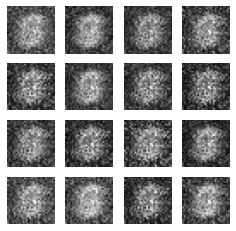

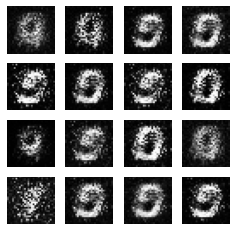

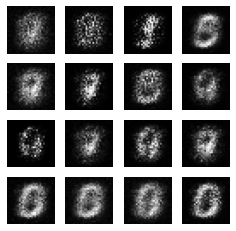

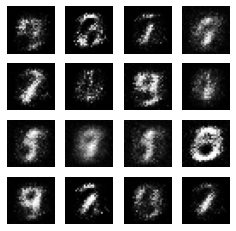

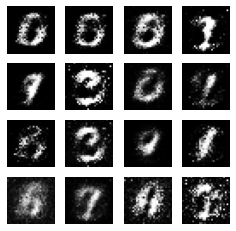

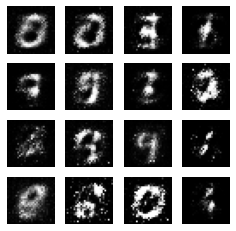

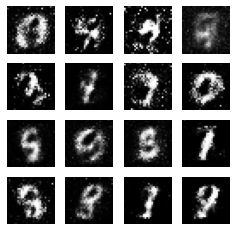

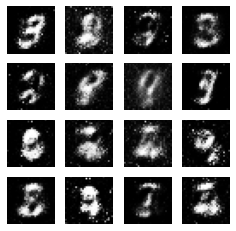

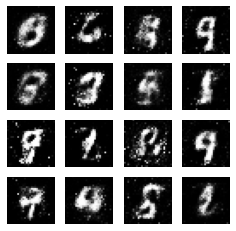

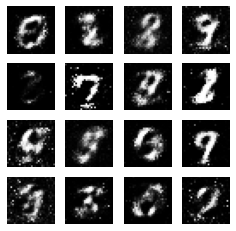

In [9]:
iterations = 10000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

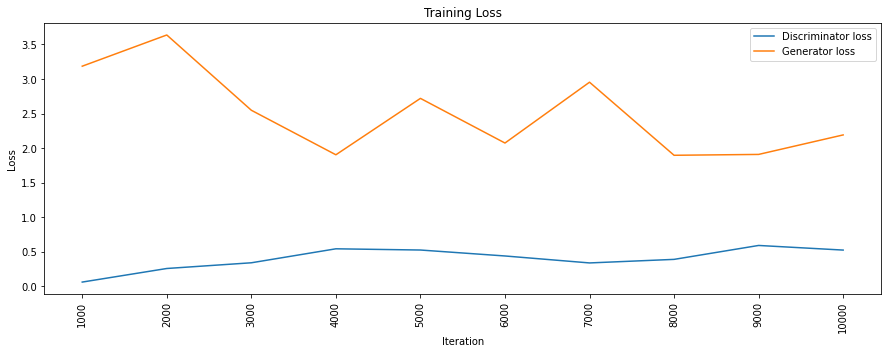

In [10]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()